#### DNN CNN
    - 독립적인 정보
    - 입력 (x) 간의 순서나 연관성을 고려하지 않는다
#### 시계열 : 시간의 연속적인 흐름
    - 시계열 데이터 : 날씨, 주식, 문장 --> 순서가 중요한 데이터
#### RNN
    - 순환하는 구조
        - 시점1(월요일) : 맑음(x1) 정보가 RNN에 들어온다 -> RNN 날씨가 맑았음(h1) 이라는 요약본을 생성
        - 시점2(화요일) : 흐림(x2) -> RNN 새로운정보(흐림, x2) + 어제의 기억(맑았음, h1) 함께 고려 해서
            어제 맑았는데 오늘 흐림 h2이라는 새로운 요약본을 생성
        - 시점3(수요일) : 비(x3) -> RNN 새로운정보(비, x3) 정보와 + 어제의 기억(어제 맑았는데 오늘 흐림 h2)
            새로운 상태 h3
        - 반복
    - 알고리즘
        - 각 시점(time step)에서 1. 현재의 입력과 2. 과거의 기억(hidden state ht-1) 받아서 
            3. 현재의 결과물과 4. 다음시점으로 넘겨줄 최신기억 ht을 생성
        - ht 기억이 시계열 데이터의 맥락(Context) 저장하는 역할
    - 장점
        - 순서가 있는 데이터의 맥락을 학습
    - 한계
        - 기억력이 생각보다 짧다
        - 시계열 데이터가 길어지면(예 100단계전의 정보)
        - 이정 정복가 소실되거나 반대로 너무 강해져서 폭주가 되서 제대로 학습이 안된다.
        - 장기 기억 의존성 문제( Long-Term Dependency Problem)
#### LSTM & GRU
    - LSTM(Long Short-Term Memory) : RNN 내부에 게이트(Gate) 복잡한 장치 -> 잊고, 기억할 정보를 관리
    - GRU(Gated Recurrent Unit) : LSTM 구조를 좀더 단순화시킨 모델, LSTM성능은 비슷, 속도는 빠르다
#### RNN 핵심수식
    - 은닉상태 계산
        - h1 = tanh(wht-1 + wxt -- bh)
    - 출력계산

In [9]:
# https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_train.csv
import pandas as pd
url = "https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_train.csv"
df = pd.read_csv(url)
df

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116
...,...,...,...,...,...,...
962,2019-10-14,284,287,282,5513200,286
963,2019-10-15,284,286,279,7685600,284
964,2019-10-16,283,288,281,16175900,286
965,2019-10-17,304,309,288,38258900,293


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


In [11]:
# EDA - 탐색적 데이터 분석

In [30]:
# 데이터셋
import numpy as np
from torch.utils.data import Dataset
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler

class StockDataset(Dataset):
    def __init__(self):
        url = "https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/time_data_train.csv"
        self.csv = pd.read_csv(url)
        data = self.csv.iloc[:, 1:-1].values
        label = self.csv.iloc[:, -1].values.reshape(-1, 1)
        self.data = torch.Tensor(StandardScaler().fit_transform(data))
        # 정답이 숫자 크다면 정규화가 학습에 도움이 된다.
        self.label = torch.Tensor(StandardScaler().fit_transform(label))
    def __len__(self):
        return len(self.data) - 30  # 사용가능한 배치 개수
    
    def __getitem__(self, idx):
        data = self.data[idx:idx+30]
        label = self.label[idx+30]
        return data, label



In [42]:
import torch.nn as nn

class StockRNN(nn.Module):
    def __init__(self):
        super(StockRNN, self).__init__()
        # (30일, 배치16개, 각 입력의 특성 3개) batch_first= False
        # (배치 16개, 30일 각 입력의 특성3개) batch_first= True
        self.rnn = nn.RNN(input_size=4, hidden_size=8, num_layers=5, batch_first=True)
        self.fc1 = nn.Linear(30*8, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x, ho): # 입력데이터는 (16, 30, 4)
        # ho는 초기 은닉상태(num_layers, batch, hidden_size)
        # 출력 x는 모든 시점에  대한 hidden output을 담고 있어야 함 (batch, seq_len, hidden_size) (16, 30, 8)
        # 출력 hn 최종은닉상태(각레이어의 마지막 타임스템프 hidden state) (num_layers, batch, hidden_size) (5, 16, 8)
        out, hn = self.rnn(x, ho)
        # mlp 입력으로 사용될수 있도록 모양 변경
        out = torch.reshape(out, (out.shape[0], -1))
        # mlp
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = torch.flatten(out)
        return out

In [43]:
rnn = StockRNN()
sample_data = torch.randn(16, 30, 4)  # 배치크기 16, 시점30, 특성4
ho = torch.zeros(5, 16, 8)  # num_layers 5, 배치16, hidden_size8
out = rnn(sample_data, ho)
out

tensor([-0.2549, -0.2603, -0.2519, -0.2529, -0.2514, -0.2608, -0.2491, -0.2542,
        -0.2428, -0.2536, -0.2516, -0.2545, -0.2533, -0.2594, -0.2561, -0.2492],
       grad_fn=<ViewBackward0>)

In [45]:
from torch.optim import Adam
from torch.utils.data import DataLoader
device =  "cuda" if torch.cuda.is_available() else "cpu"
model = StockRNN().to(device)
dataset = StockDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
optimizer = Adam(model.parameters(), lr=0.001)


In [51]:
from tqdm import tqdm
# criterian = nn.MSELoss()

for epoch in range(200):
    loop = tqdm(DataLoader)
    for data, label in dataloader:
        optimizer.zero_grad()
        # 초기 은닉상태
        ho = torch.zeros(5, data.size(0), 8).to(device)
        # 모델의 예측값
        pred = model(data.to(device),ho)
        # 손실계산
        loss = nn.MSELoss()(pred, label.to(device))
        loss.backward()
        optimizer.step()
        loop.set_description(f"Epoch {epoch+1}")
    
    torch.save(model.state_dict(), "./data/stock_rnn_model.pth")

Epoch 200: : 0it [18:29, ?it/s]
Epoch 1: : 0it [00:00, ?it/s]
Epoch 2: : 0it [00:00, ?it/s]
Epoch 3: : 0it [00:00, ?it/s]
Epoch 4: : 0it [00:00, ?it/s]
Epoch 5: : 0it [00:00, ?it/s]
Epoch 6: : 0it [00:00, ?it/s]
Epoch 7: : 0it [00:00, ?it/s]
Epoch 8: : 0it [00:00, ?it/s]
Epoch 9: : 0it [00:00, ?it/s]
Epoch 10: : 0it [00:00, ?it/s]
Epoch 11: : 0it [00:00, ?it/s]
Epoch 12: : 0it [00:00, ?it/s]
Epoch 13: : 0it [00:00, ?it/s]
Epoch 14: : 0it [00:00, ?it/s]
Epoch 15: : 0it [00:00, ?it/s]
Epoch 16: : 0it [00:00, ?it/s]
Epoch 17: : 0it [00:00, ?it/s]
Epoch 18: : 0it [00:00, ?it/s]
Epoch 19: : 0it [00:00, ?it/s]
Epoch 20: : 0it [00:00, ?it/s]
Epoch 21: : 0it [00:00, ?it/s]
Epoch 22: : 0it [00:00, ?it/s]
Epoch 23: : 0it [00:00, ?it/s]
Epoch 24: : 0it [00:00, ?it/s]
Epoch 25: : 0it [00:00, ?it/s]
Epoch 26: : 0it [00:01, ?it/s]
Epoch 27: : 0it [00:00, ?it/s]
Epoch 28: : 0it [00:00, ?it/s]
Epoch 29: : 0it [00:00, ?it/s]
Epoch 30: : 0it [00:00, ?it/s]
Epoch 31: : 0it [00:00, ?it/s]
Epoch 32: : 0it 

In [69]:
# 모델 성능평가하기
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1, shuffle=False)
preds = []
total_loss = 0
with torch.no_grad():
    model.load_state_dict(torch.load("./data/stock_rnn_model.pth", map_location=device,weights_only=False))
    for data, label in loader:
        ho = torch.zeros(5, data.size(0), 8).to(device)
        pred = model(data.to(device), ho)
        loss = nn.MSELoss()(pred, label.to(device))
        total_loss += loss.item()/len(loader)
        preds.append(pred.item())
print(f"평균 손실값: {total_loss}")

c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


평균 손실값: 0.887292910259594


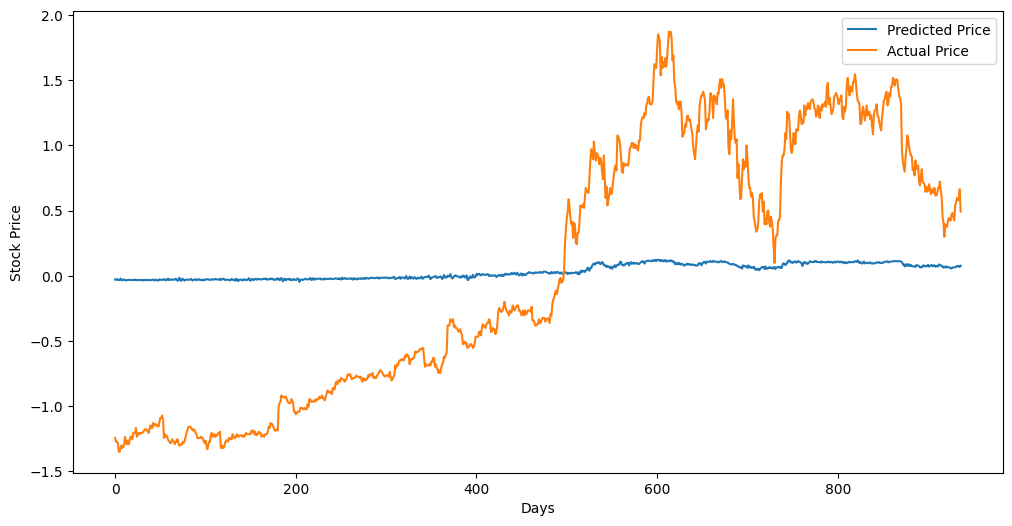

In [71]:
plt.figure(figsize=(12,6))
plt.plot(preds, label="Predicted Price")
plt.plot(dataset.label[30:], label="Actual Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [82]:
with torch.no_grad():
    last_30 = df.iloc[-30:, 1:-1].values
    X = torch.tensor(last_30, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 30, 4)
    ho = torch.zeros(5, 1, 8).to(device)
    pred = model(X, ho)
    print(f"다음날 예측 주가: {pred.item()}")

다음날 예측 주가: 0.04752856865525246


In [84]:
# yfinanace
X = np.array([
    [10,20],[100,200]
])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled


array([[-1., -1.],
       [ 1.,  1.]])

In [86]:
scaler.inverse_transform(X_scaled)

array([[ 10.,  20.],
       [100., 200.]])

In [120]:
import yfinance as yf
dat = yf.Ticker("BTC-USD")
dat.history(period="1y")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-10-29 00:00:00+00:00,69910.046875,73577.210938,69729.914062,72720.492188,58541874402,0.0,0.0
2024-10-30 00:00:00+00:00,72715.367188,72905.296875,71411.734375,72339.539062,40646637831,0.0,0.0
2024-10-31 00:00:00+00:00,72335.046875,72662.312500,69590.500000,70215.187500,40627912076,0.0,0.0
2024-11-01 00:00:00+00:00,70216.898438,71559.015625,68779.703125,69482.468750,49989795365,0.0,0.0
2024-11-02 00:00:00+00:00,69486.023438,69867.351562,69033.718750,69289.273438,18184612091,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-24 00:00:00+00:00,110069.351562,111842.531250,109770.148438,111033.921875,48160816980,0.0,0.0
2025-10-25 00:00:00+00:00,111032.617188,111947.703125,110704.406250,111641.726562,24707667305,0.0,0.0
2025-10-26 00:00:00+00:00,111639.054688,115260.906250,111268.484375,114472.445312,41708524143,0.0,0.0


In [121]:
# 독립변수, 종속변수 분리
btc_data = dat.history(period="1y")
print(btc_data.columns)  # 컬럼 확인
print(f"\n데이터 크기: {btc_data.shape}")

# 독립변수: Open, High, Low, Volume (4개 특성)
X = btc_data[['Open', 'High', 'Low', 'Volume']].values
# 종속변수: Close (예측할 종가)
y = btc_data['Close'].values.reshape(-1, 1)

print(f"\nX shape: {X.shape}")  # (365, 4)
print(f"y shape: {y.shape}")    # (365, 1)




Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

데이터 크기: (365, 7)

X shape: (365, 4)
y shape: (365, 1)


In [122]:
# window size : 30(한달치 데이터를 하나의 dataset)
window_size = 30

# 배치는 3배치
batch_size = 3

# 1. 비트코인용 Dataset 클래스 생성
class BTCDataset(Dataset):
    def __init__(self, X, y, window_size=30):
        # 정규화
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        
        self.data = torch.Tensor(self.scaler_X.fit_transform(X))
        self.label = torch.Tensor(self.scaler_y.fit_transform(y))
        self.window_size = window_size
        
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        # 30일치 데이터 -> 다음날 종가 예측
        data = self.data[idx:idx+self.window_size]
        label = self.label[idx+self.window_size]
        return data, label

# 2. 데이터셋 생성
btc_dataset = BTCDataset(X, y, window_size=window_size)
btc_loader = DataLoader(btc_dataset, batch_size=batch_size, shuffle=True)

print(f"전체 샘플 개수: {len(btc_dataset)}")
print(f"배치 개수: {len(btc_loader)}")

# 샘플 확인
sample_data, sample_label = btc_dataset[0]
print(f"\n샘플 데이터 크기: {sample_data.shape}")  # (30, 4)
print(f"샘플 레이블 크기: {sample_label.shape}")  # (1,)

전체 샘플 개수: 335
배치 개수: 112

샘플 데이터 크기: torch.Size([30, 4])
샘플 레이블 크기: torch.Size([1])


In [123]:
# 3. RNN 모델 생성 (비트코인용)
class BTCRNN(nn.Module):
    def __init__(self, input_size=4, hidden_size=16, num_layers=3):
        super(BTCRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size=input_size, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=True)
        
        self.fc1 = nn.Linear(window_size * hidden_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x, h0):
        # x: (batch, 30, 4)
        # h0: (num_layers, batch, hidden_size)
        out, hn = self.rnn(x, h0)  # out: (batch, 30, hidden_size)
        
        # Flatten
        out = out.reshape(out.size(0), -1)  # (batch, 30*hidden_size)
        
        # FC layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = out.flatten()
        
        return out

# 모델 생성
btc_model = BTCRNN(input_size=4, hidden_size=16, num_layers=3).to(device)
btc_optimizer = Adam(btc_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(btc_model)
print(f"\nDevice: {device}")

BTCRNN(
  (rnn): RNN(4, 16, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=480, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

Device: cpu


In [124]:
# 4. 학습 루프
num_epochs = 200

for epoch in range(num_epochs):
    btc_model.train()
    total_loss = 0
    
    for data, label in btc_loader:
        data, label = data.to(device), label.to(device)
        
        # 초기 은닉 상태 (num_layers, batch, hidden_size)
        h0 = torch.zeros(3, data.size(0), 16).to(device)
        
        # Forward
        btc_optimizer.zero_grad()
        pred = btc_model(data, h0)
        
        # Loss
        loss = criterion(pred, label)
        
        # Backward
        loss.backward()
        btc_optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(btc_loader)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

# 모델 저장
torch.save(btc_model.state_dict(), "./data/btc_rnn_model.pth")
print("\n모델 저장 완료!")

c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\31799\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/200], Loss: 0.731786
Epoch [20/200], Loss: 0.746372
Epoch [30/200], Loss: 0.764499
Epoch [40/200], Loss: 0.741612
Epoch [50/200], Loss: 0.773958
Epoch [60/200], Loss: 0.753625
Epoch [70/200], Loss: 0.750938
Epoch [80/200], Loss: 0.775815
Epoch [90/200], Loss: 0.744566
Epoch [100/200], Loss: 0.708817
Epoch [110/200], Loss: 0.759222
Epoch [120/200], Loss: 0.774831
Epoch [130/200], Loss: 0.771260
Epoch [140/200], Loss: 0.743566
Epoch [150/200], Loss: 0.729503
Epoch [160/200], Loss: 0.731744
Epoch [170/200], Loss: 0.753737
Epoch [180/200], Loss: 0.735495
Epoch [190/200], Loss: 0.701517
Epoch [200/200], Loss: 0.729982

모델 저장 완료!


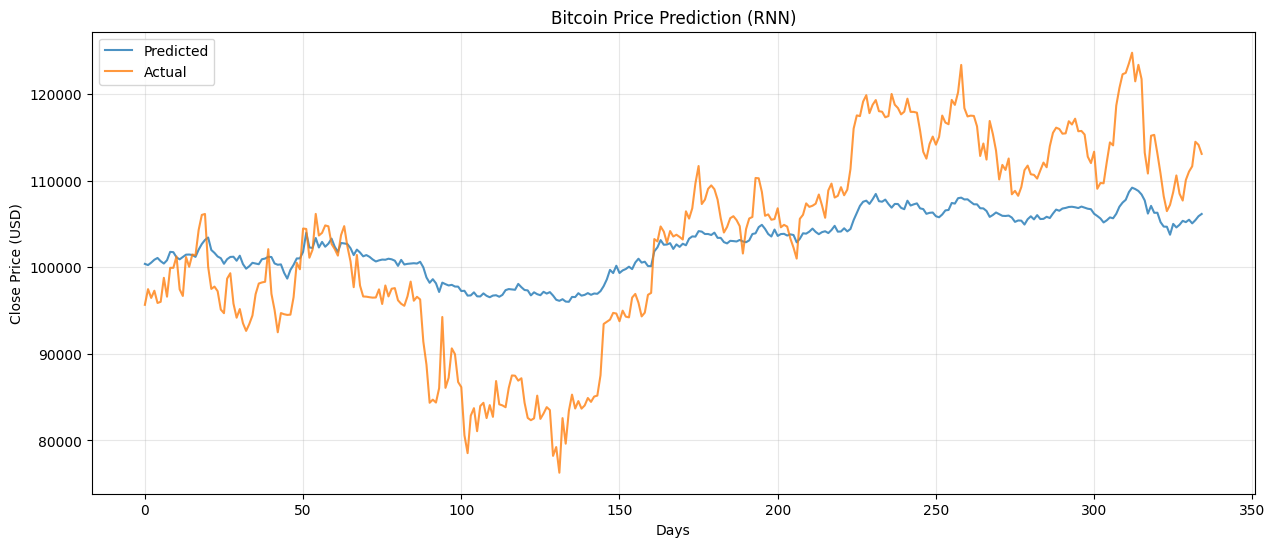


MSE: 62680175.70
MAE: 6593.20


In [125]:
# 5. 모델 평가 및 시각화
btc_model.eval()

# 전체 데이터로 예측
test_loader = DataLoader(btc_dataset, batch_size=1, shuffle=False)
predictions = []

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        h0 = torch.zeros(3, 1, 16).to(device)
        pred = btc_model(data, h0)
        predictions.append(pred.item())

# 역정규화 (원래 스케일로 복원)
predictions_original = btc_dataset.scaler_y.inverse_transform(
    np.array(predictions).reshape(-1, 1)
)
actual_original = btc_dataset.scaler_y.inverse_transform(
    btc_dataset.label[window_size:].numpy().reshape(-1, 1)
)

# 시각화
plt.figure(figsize=(15, 6))
plt.plot(predictions_original, label='Predicted', alpha=0.8)
plt.plot(actual_original, label='Actual', alpha=0.8)
plt.title('Bitcoin Price Prediction (RNN)')
plt.xlabel('Days')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 성능 평가
mse = np.mean((predictions_original - actual_original) ** 2)
mae = np.mean(np.abs(predictions_original - actual_original))
print(f"\nMSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

In [126]:
# 6. 미래 예측 (다음날 비트코인 가격)
with torch.no_grad():
    # 최근 30일 데이터
    last_30_days = btc_dataset.data[-window_size:].unsqueeze(0).to(device)  # (1, 30, 4)
    
    # 초기 은닉 상태
    h0 = torch.zeros(3, 1, 16).to(device)
    
    # 예측
    pred = btc_model(last_30_days, h0)
    
    # 역정규화
    pred_price = btc_dataset.scaler_y.inverse_transform(
        pred.cpu().numpy().reshape(-1, 1)
    )
    
    print(f"현재 비트코인 가격: ${actual_original[-1][0]:,.2f}")
    print(f"다음날 예측 가격: ${pred_price[0][0]:,.2f}")
    print(f"예상 변동: ${pred_price[0][0] - actual_original[-1][0]:,.2f} "
          f"({(pred_price[0][0] - actual_original[-1][0]) / actual_original[-1][0] * 100:.2f}%)")

현재 비트코인 가격: $113,076.26
다음날 예측 가격: $106,372.15
예상 변동: $-6,704.11 (-5.93%)
